## Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

## Load the datset

In [ ]:
dataset=pd.read_csv("train.csv")

## EDA

In [ ]:
dataset.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
dataset.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [ ]:
dataset.shape

(913000, 4)

In [ ]:
dataset.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

## Checking for Null

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


## Remove unwanted data

In [ ]:
dataset = dataset.groupby('date').sum('sales')
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.drop(['store','item'], axis=1)

In [ ]:
dataset.head()

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237


## Visualization

Text(0, 0.5, 'date')

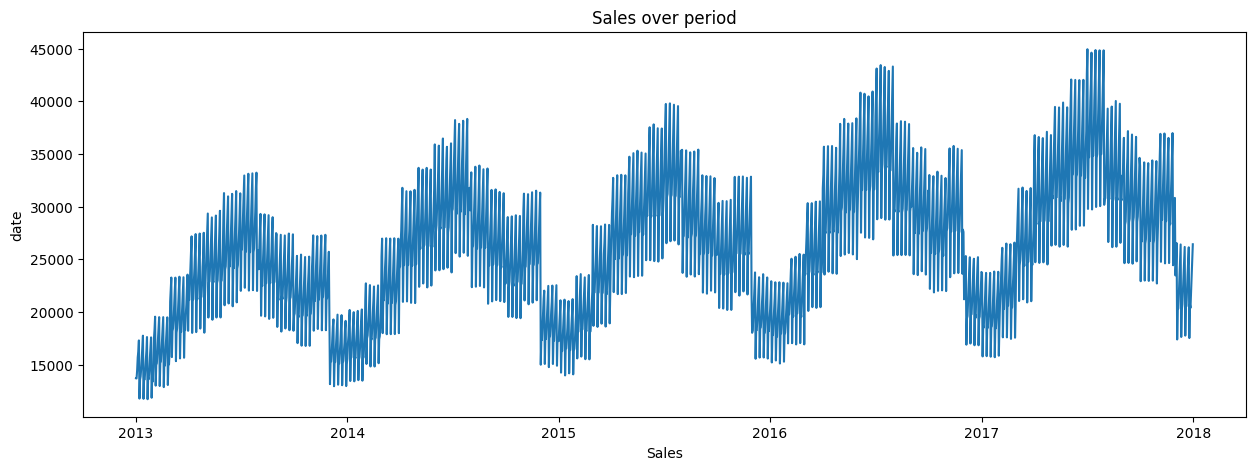

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(dataset.index,dataset['sales'])
plt.title("Sales over period")
plt.xlabel("Sales")
plt.ylabel("date")

## Spliting Train and Test data

In [ ]:
train_data,test_data=train_test_split(dataset,test_size=0.2,shuffle=False)
print(train_data)
print(test_data)

            sales
date             
2013-01-01  13696
2013-01-02  13678
2013-01-03  14488
2013-01-04  15677
2013-01-05  16237
...           ...
2016-12-26  16831
2016-12-27  19341
2016-12-28  19560
2016-12-29  21111
2016-12-30  22296

[1460 rows x 1 columns]
            sales
date             
2016-12-31  23792
2017-01-01  23709
2017-01-02  15772
2017-01-03  18650
2017-01-04  18510
...           ...
2017-12-27  20378
2017-12-28  21885
2017-12-29  23535
2017-12-30  24988
2017-12-31  26420

[366 rows x 1 columns]


## Visualizing train and test data

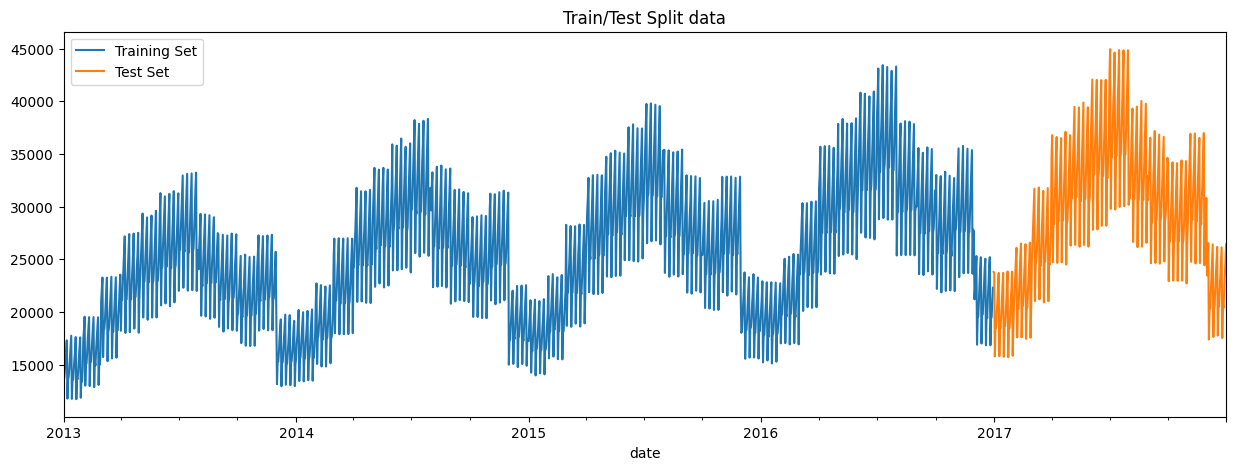

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label='Training Set', title='Train/Test Split data')
test_data.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

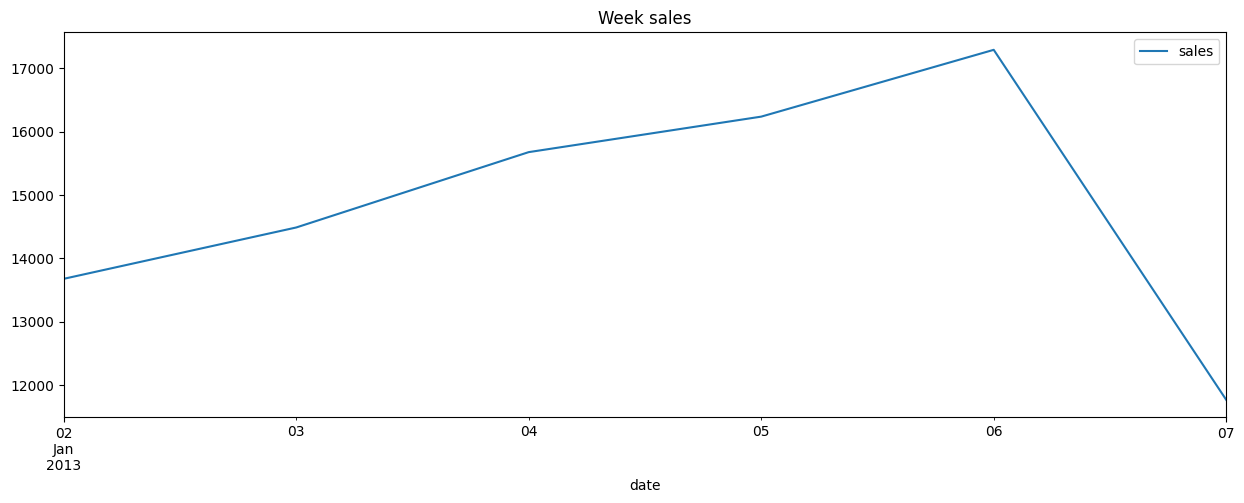

In [ ]:
dataset.loc[(dataset.index > '01-01-2013') & (dataset.index < '01-08-2013')] \
    .plot(figsize=(15, 5), title='Week sales')
plt.show()

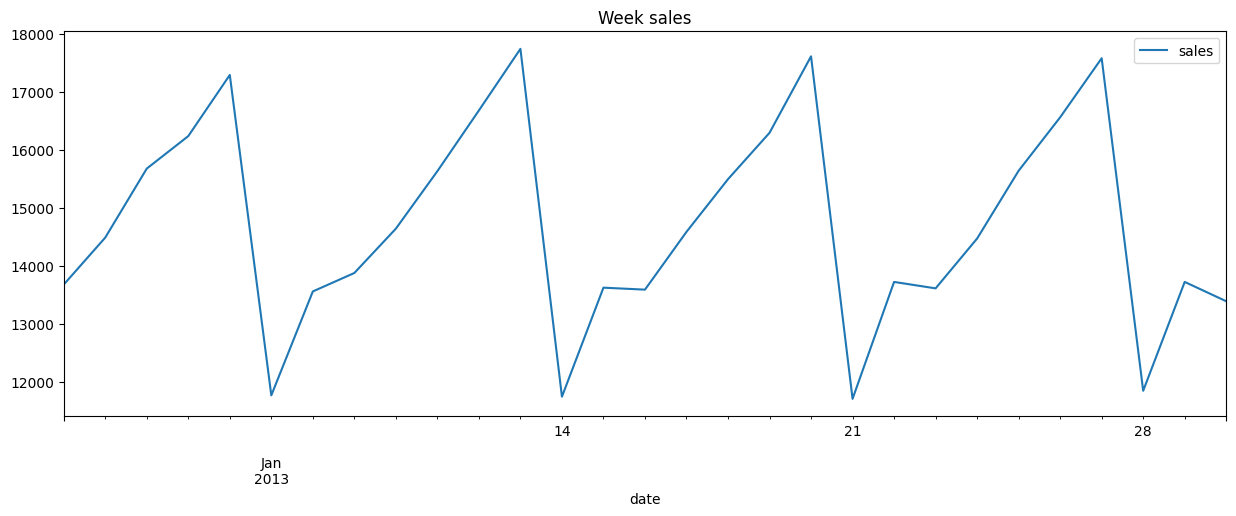

In [ ]:
dataset.loc[(dataset.index > '01-01-2013') & (dataset.index < '01-31-2013')] \
    .plot(figsize=(15, 5), title='Week sales')
plt.show()

## Feature Engineering

In [ ]:
def create_features(df):
    """
    Creating time series features based on dataframe index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(dataset)

In [ ]:
print(df)

            sales  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
date                                                                        
2013-01-01  13696          1        1      1  2013          1           1   
2013-01-02  13678          2        1      1  2013          2           2   
2013-01-03  14488          3        1      1  2013          3           3   
2013-01-04  15677          4        1      1  2013          4           4   
2013-01-05  16237          5        1      1  2013          5           5   
...           ...        ...      ...    ...   ...        ...         ...   
2017-12-27  20378          2        4     12  2017        361          27   
2017-12-28  21885          3        4     12  2017        362          28   
2017-12-29  23535          4        4     12  2017        363          29   
2017-12-30  24988          5        4     12  2017        364          30   
2017-12-31  26420          6        4     12  2017        365          31   

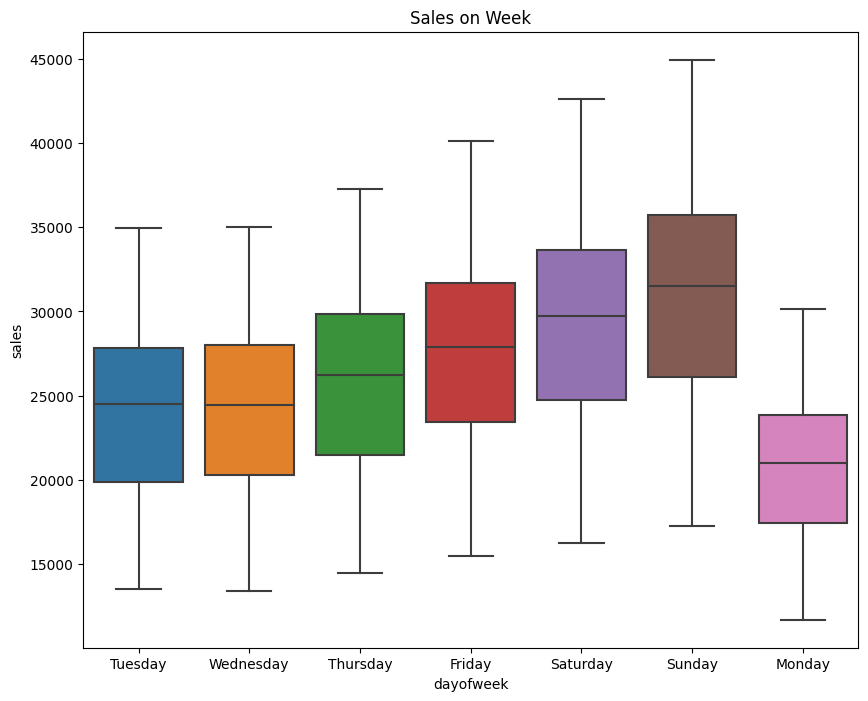

In [ ]:
week_day_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}
df_temp = df.copy()
df_temp['dayofweek'] = df_temp['dayofweek'].map(lambda index: week_day_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='dayofweek', y='sales')
ax.set_title('Sales on Week')
plt.show()

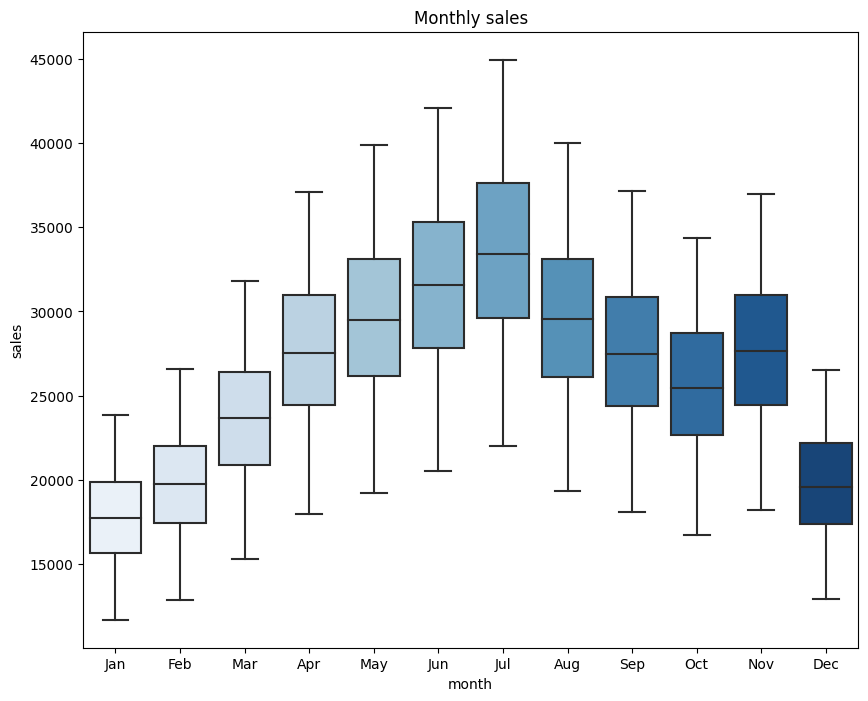

In [ ]:
month_map = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}
df_temp=df.copy()
df_temp['month']=df_temp['month'].map(lambda index:month_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='month', y='sales',palette='Blues')
ax.set_title('Monthly sales')
plt.show()

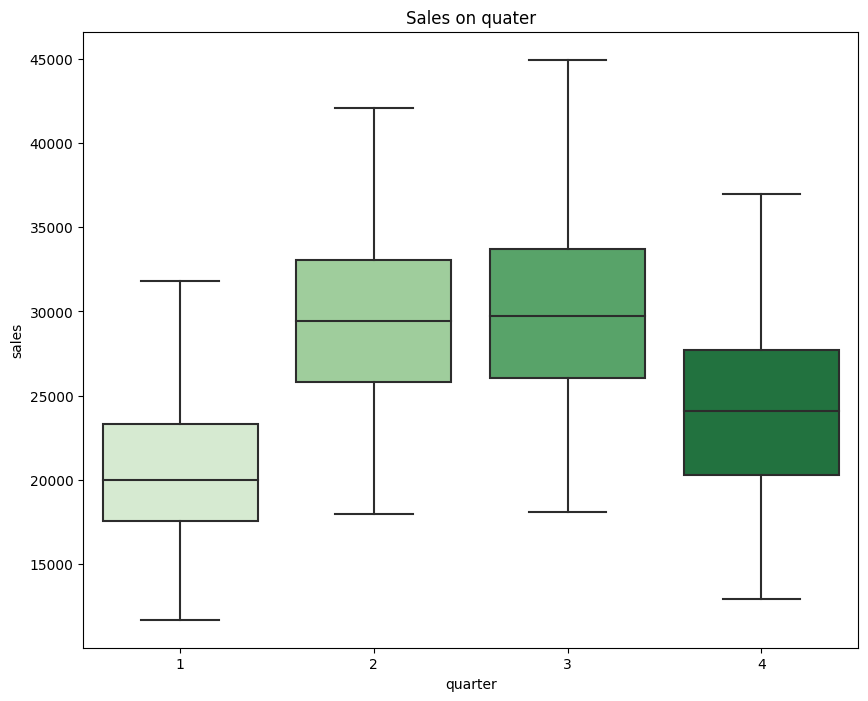

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='sales',palette='Greens')
ax.set_title('Sales on quater')
plt.show()

## Spliting into Features and Target

In [ ]:
train_data=create_features(train_data)
test_data=create_features(test_data)

In [ ]:
FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sales'

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

## Creating Linear Regression model


In [ ]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

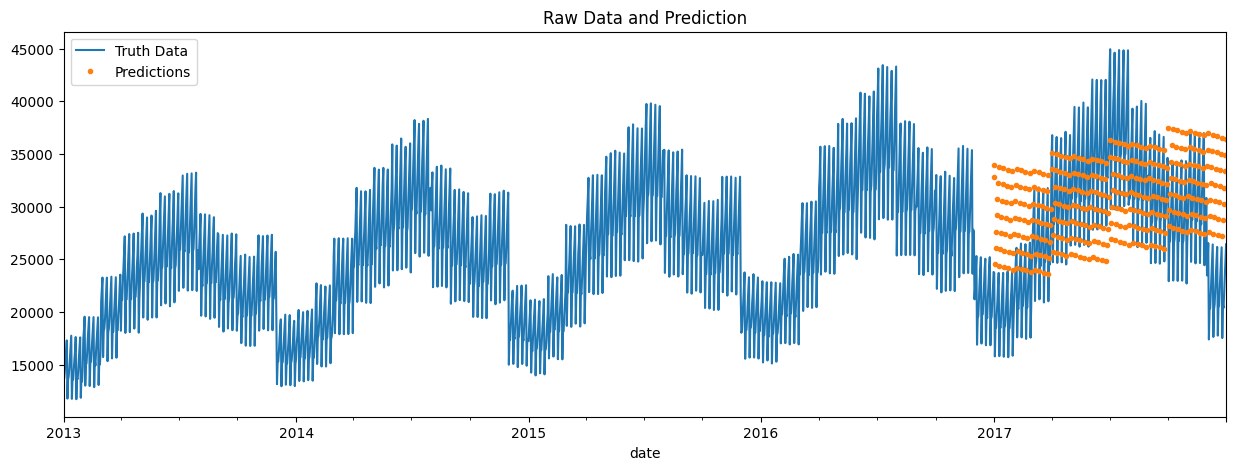

In [ ]:
test_data['lr_pred']=lr.predict(X_test)
df = df.merge(test_data[['lr_pred']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['lr_pred'].plot(ax=ax,style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()


In [ ]:
linreg_rmse = np.sqrt(mean_squared_error(test_data['sales'], test_data['lr_pred']))
linreg_mae = mean_absolute_error(test_data['sales'], test_data['lr_pred'])
linreg_r2 = r2_score(test_data['sales'], test_data['lr_pred'])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  5363.747964528408
Linear Regression MAE:  4329.290262775738
Linear Regression R2 Score:  0.31963886586635337


## Random Forest

In [ ]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

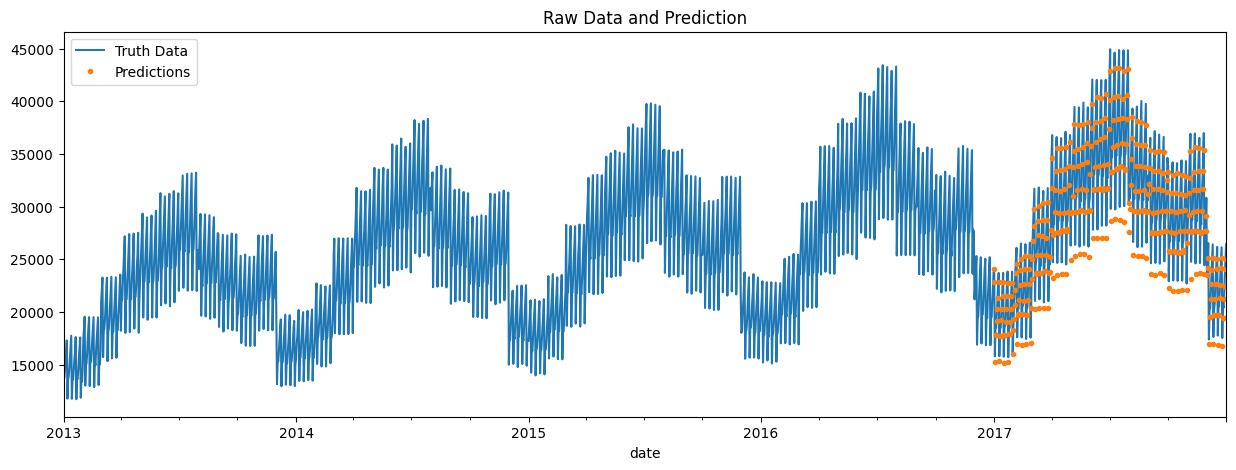

In [ ]:
test_data['rf_pred']=rf.predict(X_test)
df=df.merge(test_data[['rf_pred']],how='left',left_index=True,right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['rf_pred'].plot(ax=ax,style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()


In [ ]:
rf_rmse = np.sqrt(mean_squared_error(test_data['sales'], test_data['rf_pred']))
rf_mae = mean_absolute_error(test_data['sales'], test_data['rf_pred'])
rf_r2 = r2_score(test_data['sales'], test_data['rf_pred'])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  1216.5297357231486
Random Forest MAE:  1135.9284972677597
Random Forest R2 Score:  0.9650015969132746


## XG Boost

In [ ]:
reg = XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[01:35:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25782.56737	validation_1-rmse:29847.22902
[100]	validation_0-rmse:9898.13754	validation_1-rmse:13253.93255
[200]	validation_0-rmse:4184.52472	validation_1-rmse:6506.76327
[300]	validation_0-rmse:2115.09892	validation_1-rmse:3840.47195
[400]	validation_0-rmse:1312.17795	validation_1-rmse:2658.70880
[500]	validation_0-rmse:929.75494	validation_1-rmse:2078.27608
[600]	validation_0-rmse:681.83498	validation_1-rmse:1745.97489
[700]	validation_0-rmse:521.50118	validation_1-rmse:1559.37175
[800]	validation_0-rmse:414.60728	validation_1-rmse:1438.61667
[900]	validation_0-rmse:338.38906	validation_1-rmse:1359.62250
[999]	validation_0-rmse:284.40983	validation_1-rmse:1309.43912


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

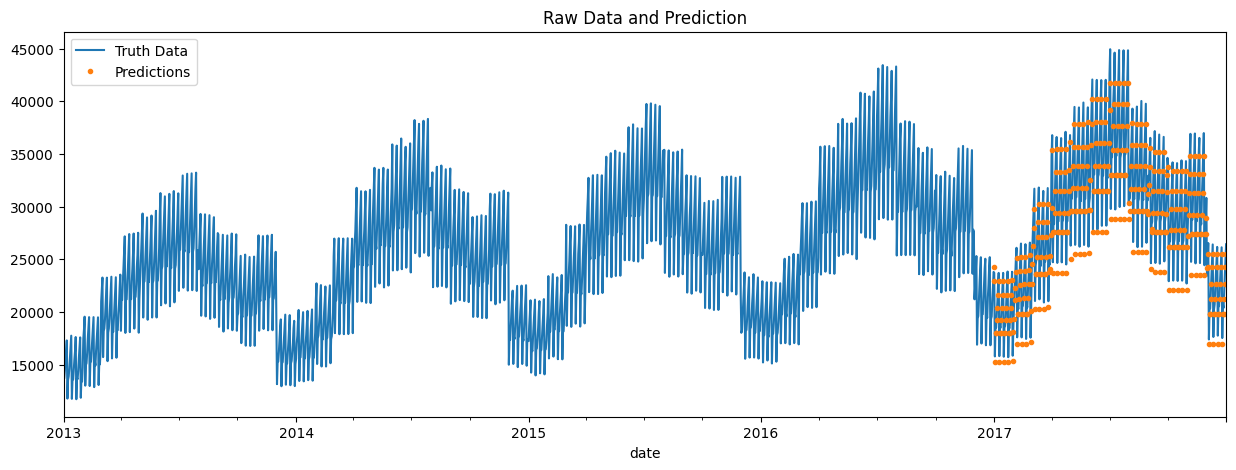

In [ ]:
test_data['prediction_xg'] = reg.predict(X_test)
df = df.merge(test_data[['prediction_xg']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_xg'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
xgb_rmse = np.sqrt(mean_squared_error(test_data['sales'], test_data['prediction_xg']))
xgb_mae = mean_absolute_error(test_data['sales'], test_data['prediction_xg'])
xgb_r2 = r2_score(test_data['sales'], test_data['prediction_xg'])
print('XGB RMSE: ', rf_rmse)
print('XGB Forest MAE: ', rf_mae)
print('XGB Forest R2 Score: ', rf_r2)

XGB RMSE:  1216.5297357231486
XGB Forest MAE:  1135.9284972677597
XGB Forest R2 Score:  0.9650015969132746


## Feature Importance

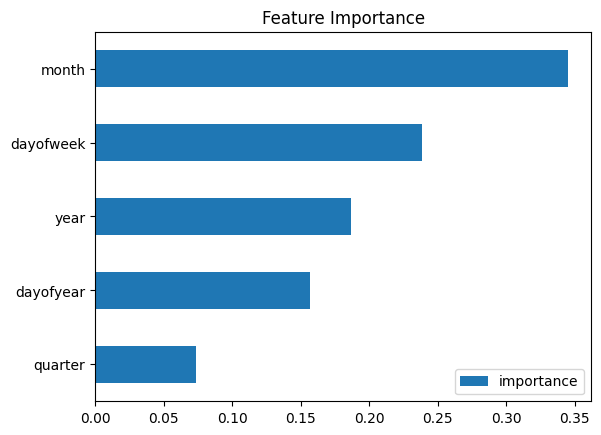

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

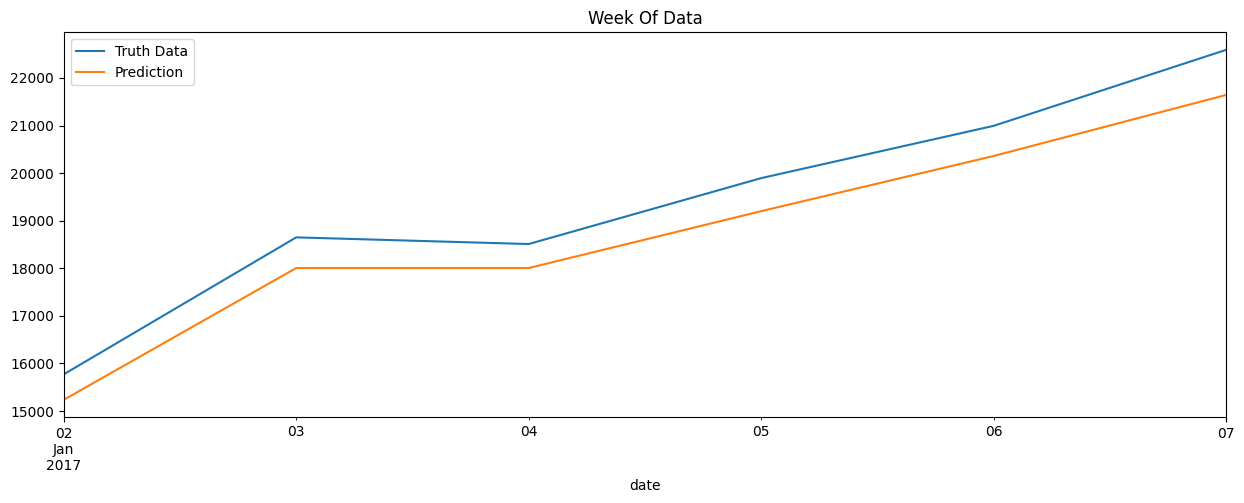

In [ ]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['sales'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['prediction_xg'] \
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

## Comparing the performance of models

In [ ]:
linreg_stats = [linreg_rmse, linreg_mae, linreg_r2]
rf_stats = [rf_rmse, rf_mae, rf_r2]
xgb_stats = [xgb_rmse, xgb_mae, xgb_r2]

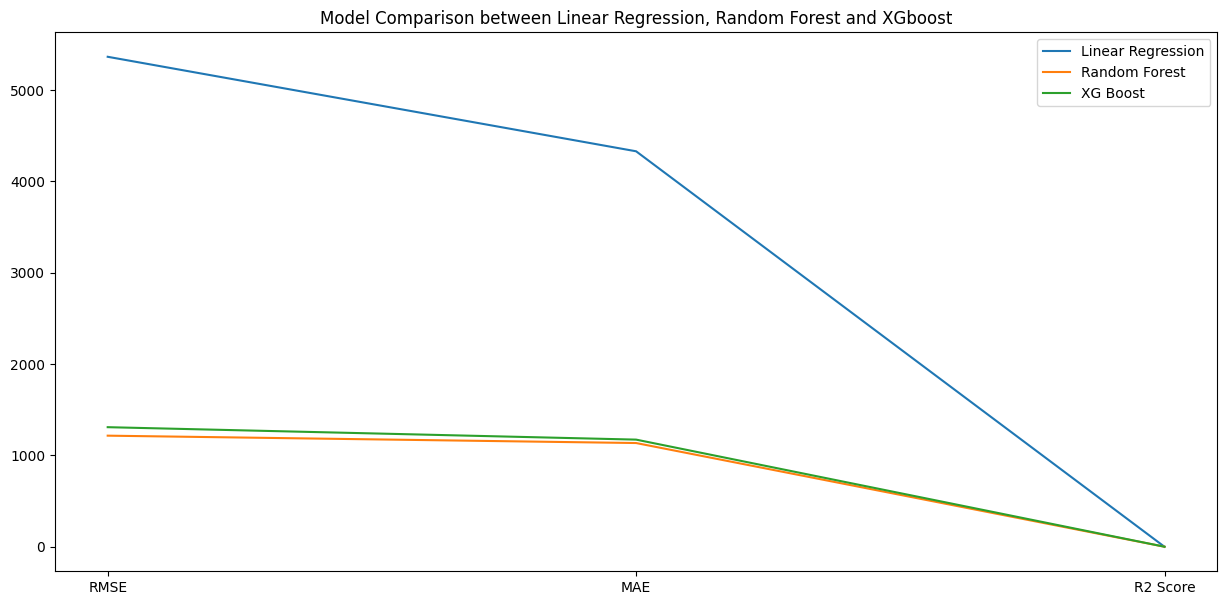

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(linreg_stats)
plt.plot(rf_stats)
plt.plot(xgb_stats)
plt.title("Model Comparison between Linear Regression, Random Forest and XGboost")
plt.xticks([0,1,2], labels=['RMSE','MAE','R2 Score'])
plt.legend(["Linear Regression", "Random Forest", "XG Boost"])
plt.show()

## Assigning XG Boost as best prediction

In [ ]:
test_data['prediction']=test_data['prediction_xg']
df['prediction']=df['prediction_xg']

## Calculate Error

In [ ]:
test_data['error'] = np.abs(test_data[TARGET] - test_data['prediction'])
test_data['dates'] = test_data.index.date

In [ ]:
test_data.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-04-01    4893.890625
2017-07-01    3445.601562
2017-07-02    3230.304688
2017-07-16    3150.304688
2017-07-30    3126.304688
2017-07-23    3125.304688
2017-07-09    2904.304688
2017-07-22    2784.839844
2017-07-14    2479.972656
2017-07-15    2441.839844
Name: error, dtype: float64

## Predict Yearly Future Values

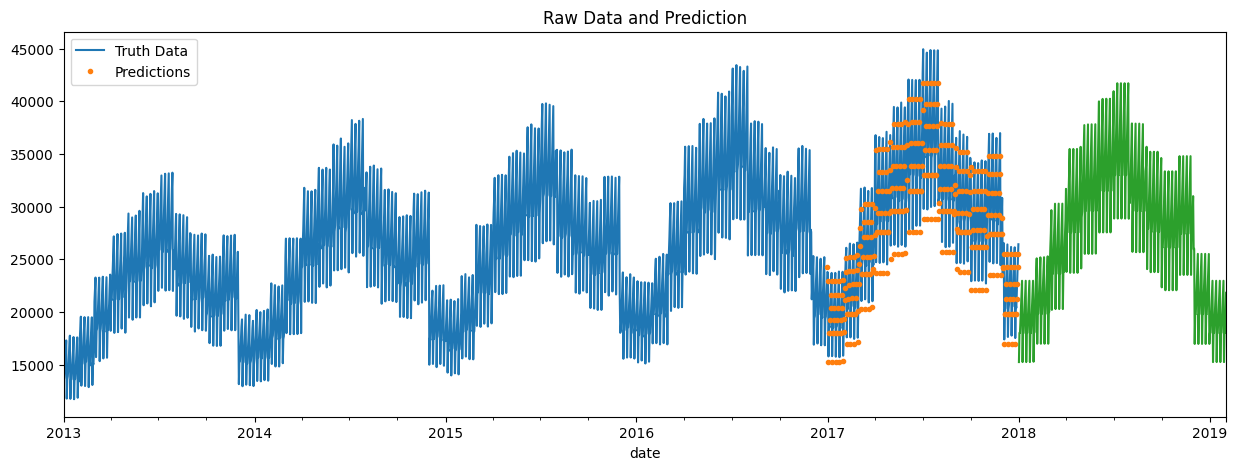

In [ ]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2019-02-01"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

## For monthly prediction

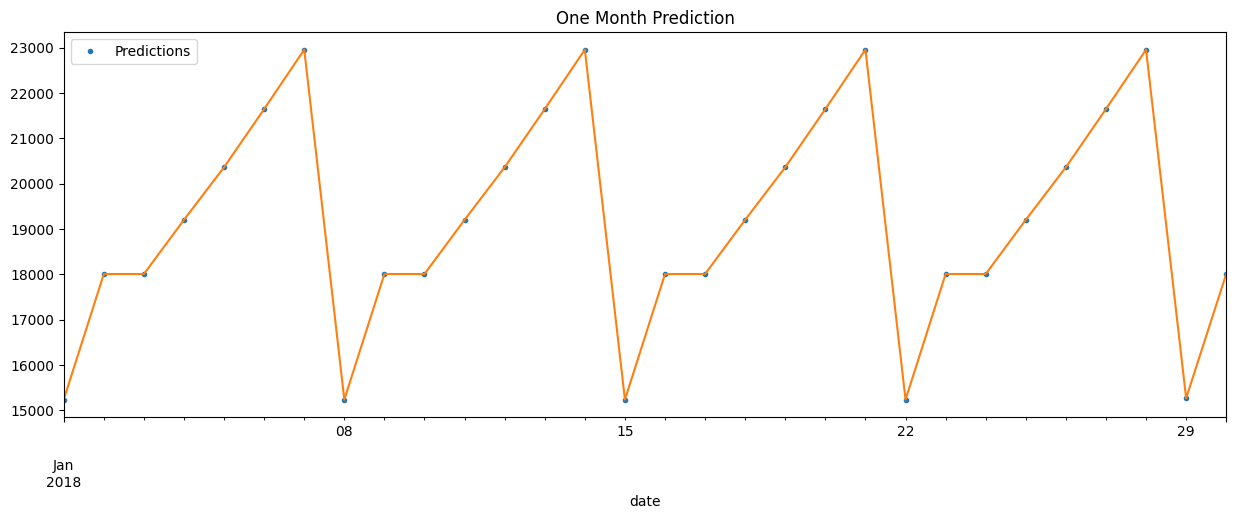

In [ ]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2018-01-30"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = to_predict_feature['prediction'].plot(figsize=(15, 5), style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Predictions'])
ax.set_title('One Month Prediction')
plt.show()